### Формирование модели машинного обучения

Текущий ноутбук рассматривает анализ датасета [Palmer Archipelago (Antarctica) penguin data](https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data).

В работе рассматривается:
1. обучение регрессионной модели для классифицирования вида пингвина на основе всех остальных признаков;
2. сохранение обученной модели в виде **конвейера обработки данных** для последующего использования.

In [51]:
import numpy as np
import pandas as pd
from seaborn import pairplot
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from pickle import dump
from pathlib import Path

In [52]:
col_names = ("species", "island", "culmen_length_mm", "culmen_depth_mm", "flipper_length_mm", 
             "body_mass_g", "sex")
df = pd.read_csv("../data/penguins_size.csv")

In [53]:
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


Часть столбцов имеют не числовые данные - преобразуем

In [55]:
#Получаем информацию о нулевых значениях в колонках
df.isnull().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

In [56]:
#Очищаем пустые значения
df.dropna(how="any", inplace=True)

In [57]:
#Посмотрим соотношение количества пингвинов разных полов
df["sex"].value_counts()

MALE      168
FEMALE    165
.           1
Name: sex, dtype: int64

In [58]:
#Уберём значение с точкой из статистики
df = df[df["sex"] != "."]
df["sex"].value_counts()

MALE      168
FEMALE    165
Name: sex, dtype: int64

In [59]:
df["species"] = df["species"].map({
    "Adelie": 0, "Chinstrap": 1, "Gentoo": 2, 
})

In [60]:
df["island"] = df["island"].map({
    "Biscoe": 0, "Dream": 1, "Torgersen": 2, 
})

In [61]:
df["sex"] = df["sex"].map({
    "MALE": 0, "FEMALE": 1
})

In [62]:
#Так как у острова категорий больше, кодируем one-hot-ом
# df = pd.get_dummies(df, columns=['island'])
# df

In [63]:
#Так как у пингвинов категорий больше, кодируем one-hot-ом
# df = pd.get_dummies(df, columns=['species'])
# df

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    int64  
 1   island             333 non-null    int64  
 2   culmen_length_mm   333 non-null    float64
 3   culmen_depth_mm    333 non-null    float64
 4   flipper_length_mm  333 non-null    float64
 5   body_mass_g        333 non-null    float64
 6   sex                333 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 20.8 KB


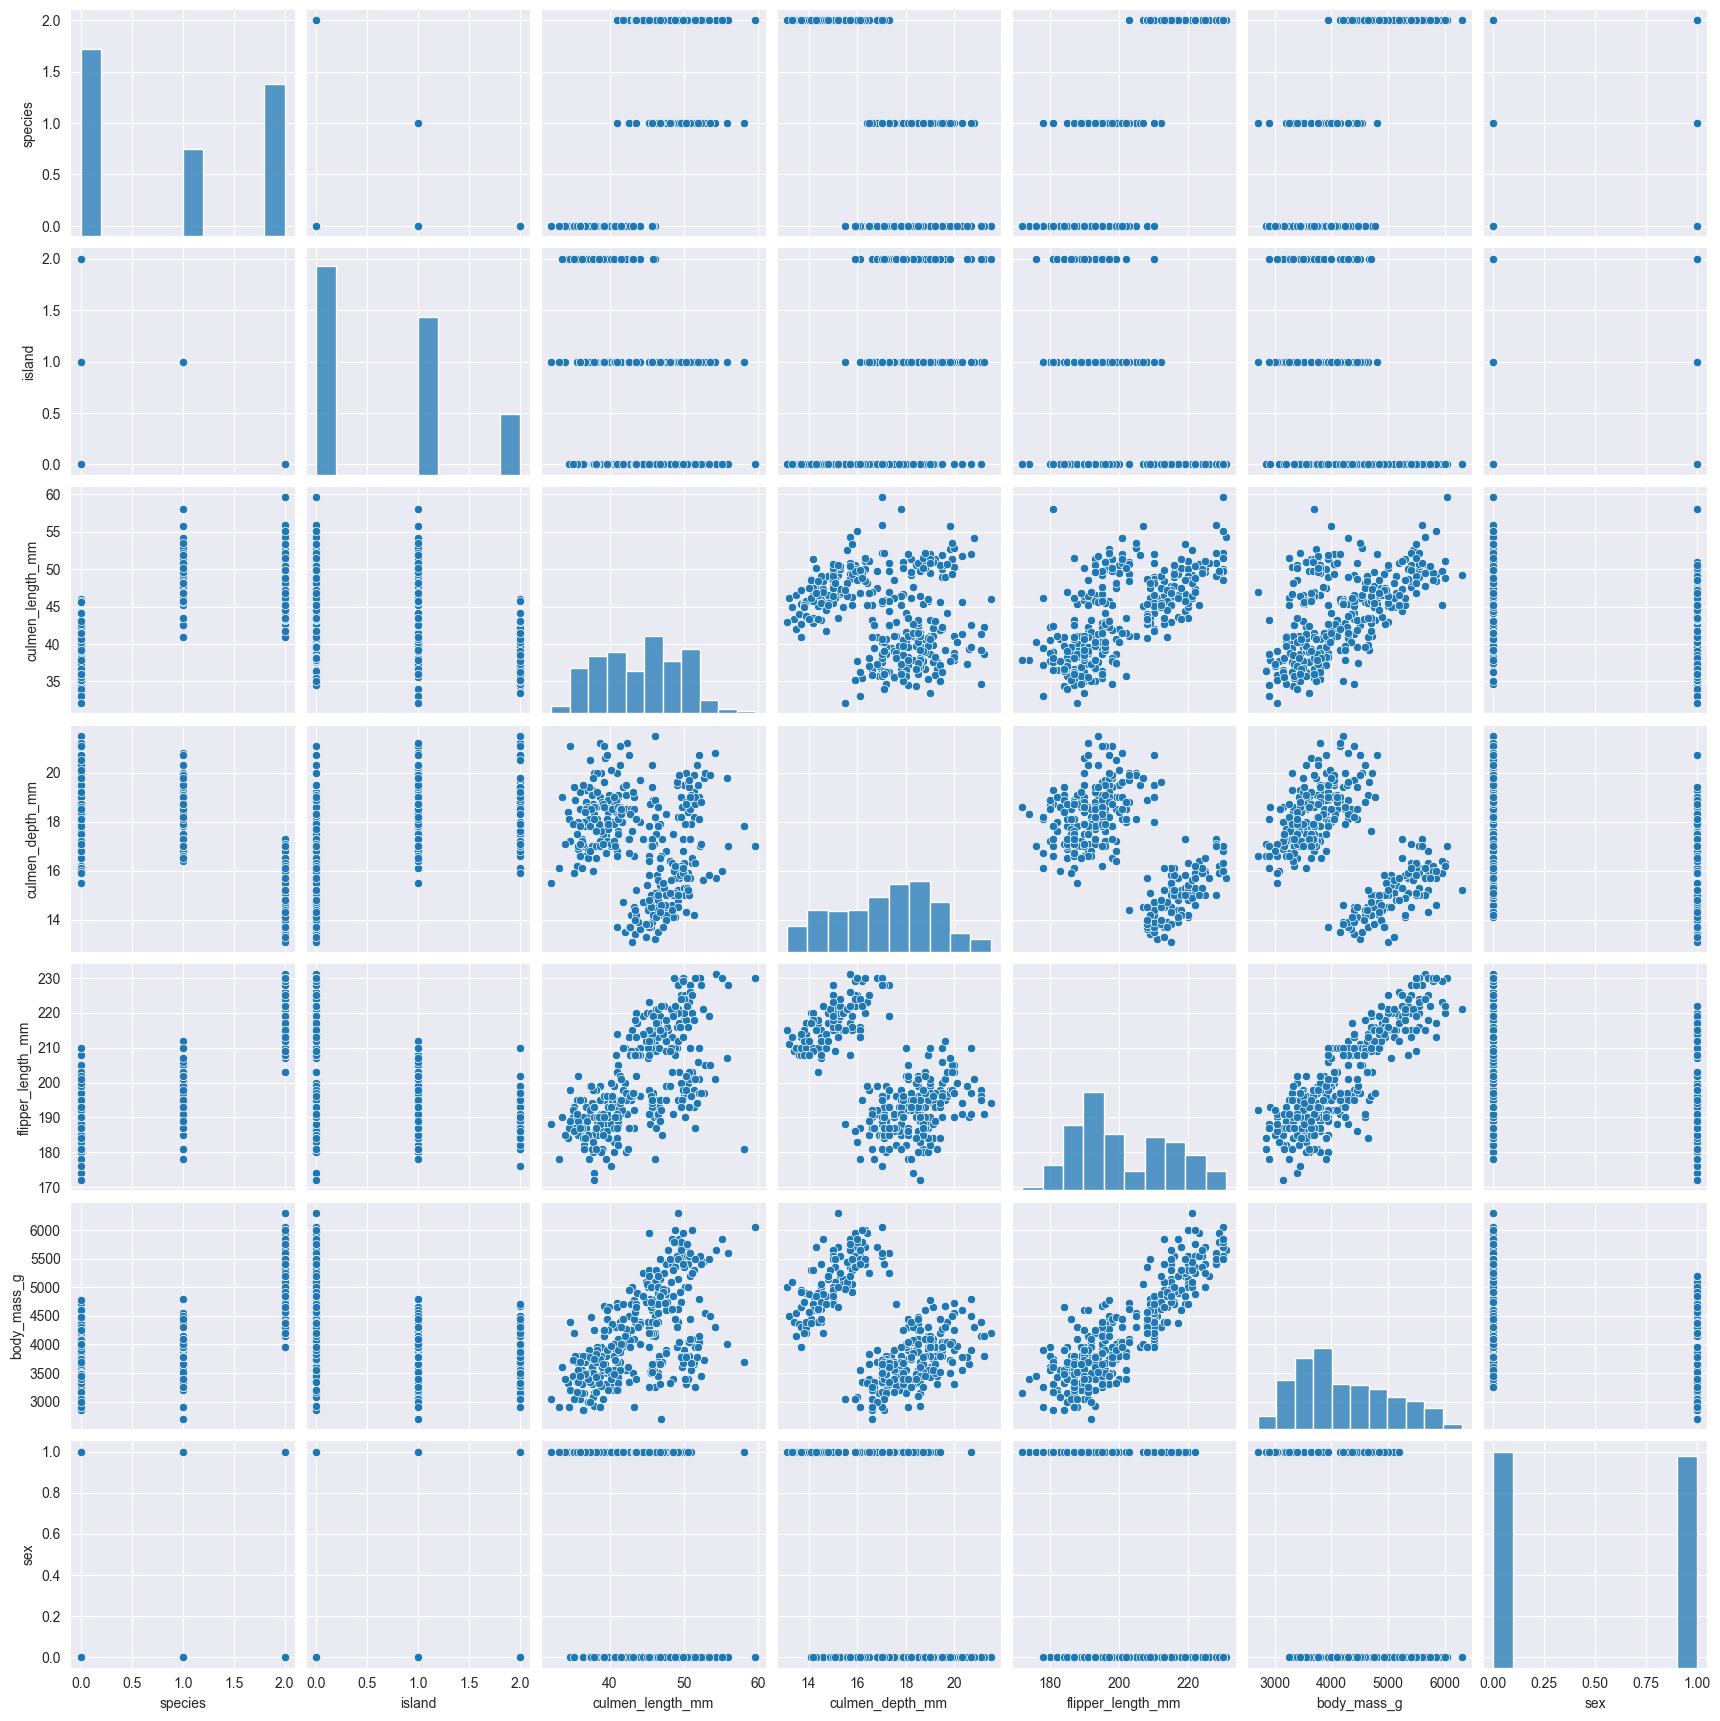

In [65]:
pairplot(df)

Посмторим на распределение категориальных переменных.

In [66]:
df["species"].value_counts()

0    146
2    119
1     68
Name: species, dtype: int64

In [67]:
df["island"].value_counts()

0    163
1    123
2     47
Name: island, dtype: int64

Выясним, содержатся ли выбросы в данных.

<Axes: >

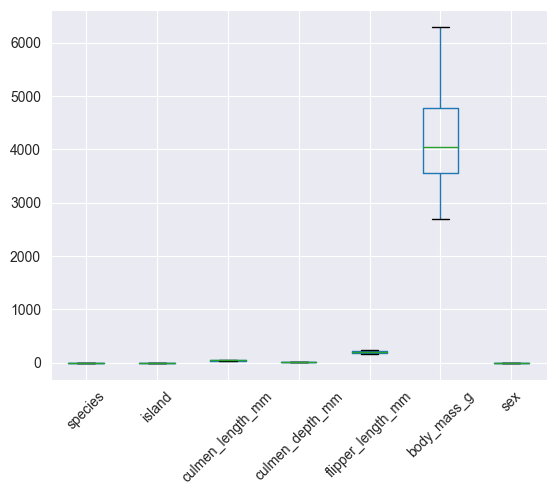

In [68]:
df[["species", "island", "culmen_length_mm", "culmen_depth_mm", "flipper_length_mm", 
             "body_mass_g", "sex"]].boxplot(rot=45)

Сформируем конвейеры для обработки количественных и категориальных данных.

In [69]:
numeric_features = ["culmen_length_mm", "culmen_depth_mm", "flipper_length_mm", 
             "body_mass_g", "sex"]
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")), 
        ("scaler", StandardScaler()),
    ]
)

In [70]:
categorical_features = ["species", "island"]
categorical_transformer = Pipeline(
    steps=[
        ("onehot-encoder", OneHotEncoder(drop="first", 
                                         handle_unknown="ignore")),
    ]
)

In [71]:
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, categorical_features),
    ]
)

In [72]:
regressor = Ridge()
tr_regressor = TransformedTargetRegressor(regressor=regressor,
                                          transformer=MinMaxScaler())
pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("regressor", tr_regressor)
    ]
)

In [73]:
train, test = train_test_split(df, test_size=0.3)

In [74]:
train.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
197,1,1,50.8,18.5,201.0,4450.0,0
318,2,0,48.4,14.4,203.0,4625.0,1
59,0,0,37.6,19.1,194.0,3750.0,0
36,0,1,38.8,20.0,190.0,3950.0,0
53,0,0,42.0,19.5,200.0,4050.0,0


In [75]:
X_train = train[["culmen_depth_mm", "flipper_length_mm","body_mass_g", "sex","species", "island"]]
Y_train = train[["culmen_length_mm"]]

In [76]:
X_test = test[["culmen_depth_mm", "flipper_length_mm","body_mass_g", "sex","species", "island"]]
Y_test = test[["culmen_length_mm"]]

Подберем коэффициент регуляризации для линейной регрессии.

In [77]:
param_grid = {
    "regressor__regressor__alpha": np.linspace(0.0, 3.0, num=31),
}

In [78]:
search_cv = GridSearchCV(pipe, param_grid)

In [79]:
search_cv.fit(X_train, Y_train)

ValueError: 
All the 155 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
155 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Кирилл\PycharmProjects\CloudCS-Lab1\venv\lib\site-packages\pandas\core\indexes\base.py", line 3802, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 165, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 5745, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 5753, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'culmen_length_mm'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\Кирилл\PycharmProjects\CloudCS-Lab1\venv\lib\site-packages\sklearn\utils\__init__.py", line 448, in _get_column_indices
    col_idx = all_columns.get_loc(col)
  File "C:\Users\Кирилл\PycharmProjects\CloudCS-Lab1\venv\lib\site-packages\pandas\core\indexes\base.py", line 3804, in get_loc
    raise KeyError(key) from err
KeyError: 'culmen_length_mm'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\Кирилл\PycharmProjects\CloudCS-Lab1\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Кирилл\PycharmProjects\CloudCS-Lab1\venv\lib\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Кирилл\PycharmProjects\CloudCS-Lab1\venv\lib\site-packages\sklearn\pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\Кирилл\PycharmProjects\CloudCS-Lab1\venv\lib\site-packages\joblib\memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\Кирилл\PycharmProjects\CloudCS-Lab1\venv\lib\site-packages\sklearn\pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\Кирилл\PycharmProjects\CloudCS-Lab1\venv\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "C:\Users\Кирилл\PycharmProjects\CloudCS-Lab1\venv\lib\site-packages\sklearn\compose\_column_transformer.py", line 724, in fit_transform
    self._validate_column_callables(X)
  File "C:\Users\Кирилл\PycharmProjects\CloudCS-Lab1\venv\lib\site-packages\sklearn\compose\_column_transformer.py", line 426, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
  File "C:\Users\Кирилл\PycharmProjects\CloudCS-Lab1\venv\lib\site-packages\sklearn\utils\__init__.py", line 456, in _get_column_indices
    raise ValueError("A given column is not a column of the dataframe") from e
ValueError: A given column is not a column of the dataframe


In [ ]:
print("Best params:")
print(search_cv.best_params_)

In [80]:
search_cv.score(X_train, Y_train)

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [81]:
search_cv.score(X_test, Y_test)

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

Сохраним полученный конвейер обработки данных для дальнейшего использования.

In [82]:
Path("../models").mkdir(parents=True, exist_ok=True)

with open("../models/pipeline.pkl", "wb") as file:
    dump(search_cv, file)